# 載入相關套件


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import scipy.cluster.hierarchy as sch
import datetime
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import pairwise_distances

# 載入資料集

In [2]:
iris = load_iris()
iris.data

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
       [4.9, 3

In [3]:
iris.target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

# Purity運算函式

In [4]:
def purity_score(y_true, y_pred):
    """純度值
        參數
            y_true(np.ndarray): n*1 矩陣之實際labels
            y_pred(np.ndarray): n*1 矩陣預測群數

        Returns:
            float: puritr值
    """
    # matrix which will hold the majority-voted labels
    #生成一個真實標籤大小的矩陣，且個數皆為0
    y_voted_labels = np.zeros(y_true.shape) #e.g. array([0., 0., 0.,..., 0., 0.])
    
    # 排序標籤 Ordering labels
    ## 標籤可能會遺失，像是某集合(0,2)，其中缺少1。Labels might be missing e.g with set like 0,2 where 1 is missing
    ## 首先找到唯一標籤，然後將標籤變成有順序的集合。First find the unique labels, then map the labels to an ordered set
    ## 0,2就會變成0,1。0,2 should become 0,1
    
    #讀取標籤類別個數
    labels = np.unique(y_true) #e.g. array([0, 1, 2])
    
    ordered_labels = np.arange(labels.shape[0]) #e.g. array([0, 1, 2])
    for k in range(labels.shape[0]):
        #將資料集y的類別放進ordered_labels
        y_true[y_true==labels[k]] = ordered_labels[k]
        
    # 更新唯一標籤。Update unique labels
    labels = np.unique(y_true)
    # 我們將bins的數量設定為n_classes+2。We set the number of bins to be n_classes+2 so that 
    # 我們計算兩個連續bins之間類別的實際發生次數。we count the actual occurence of classes between two consecutive bins
    # 較大的會被排除掉。the bigger being excluded [bin_i, bin_i+1]
    bins = np.concatenate((labels, [np.max(labels)+1]), axis=0) #e.g. array([0, 1, 2, 3])

    for cluster in np.unique(y_pred):
        hist, _ = np.histogram(y_true[y_pred==cluster], bins=bins)
        # 找群中最常見的標籤。Find the most present label in the cluster
        winner = np.argmax(hist)
        y_voted_labels[y_pred==cluster] = winner

    return accuracy_score(y_true, y_voted_labels)

# 原始分群

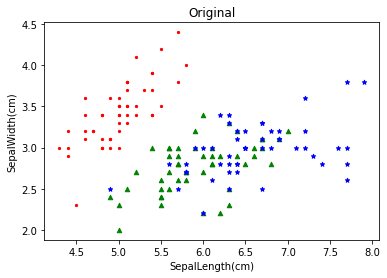

In [5]:
plt.title("Original")
plt.xlabel('SepalLength(cm)')
plt.ylabel('SepalWidth(cm)')
x = iris.data[iris.target==0]
y = iris.data[iris.target==1]
z = iris.data[iris.target==2]
plt.scatter(x[:, 0], x[:, 1], c="red", marker='.',s=20)  
plt.scatter(y[:, 0], y[:, 1], c="green", marker='^',s=20)  
plt.scatter(z[:, 0], z[:, 1], c="blue", marker='*',s=20)  
#scatter=plt.scatter(iris.data[:,0],iris.data[:,1],c=Kclustering.labels_)

In [6]:
np.unique(iris.target)

array([0, 1, 2])

# K-Mean

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 0 0 0 0 2 0 0 0 0
 0 0 2 2 0 0 0 0 2 0 2 0 2 0 0 2 2 0 0 0 0 0 2 0 0 0 0 2 0 0 0 2 0 0 0 2 0
 0 2]
執行時間： 0:00:00.028919
Purity: 0.8933333333333333
Silhouette Coefficient: 0.5528190123564091


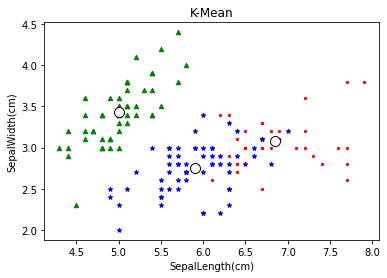

In [7]:
#起始時間
start = datetime.datetime.now()
#訓練
Kclustering= KMeans(n_clusters = 3).fit(iris.data)
#結束時間
end = datetime.datetime.now()
#機器自動分群並預測結果
print(Kclustering.labels_)
#散佈圖
plt.title('K-Mean')
plt.xlabel('SepalLength(cm)')
plt.ylabel('SepalWidth(cm)')
x = iris.data[Kclustering.labels_==0]
y = iris.data[Kclustering.labels_==1]
z = iris.data[Kclustering.labels_==2]
plt.scatter(x[:, 0], x[:, 1], c="red", marker='.',s=20)  
plt.scatter(y[:, 0], y[:, 1], c="green", marker='^',s=20)  
plt.scatter(z[:, 0], z[:, 1], c="blue", marker='*',s=20)
#scatter=plt.scatter(iris.data[:,0],iris.data[:,1],c=Kclustering.labe}ls_)
#中心點
centers = Kclustering.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='white', marker='o', edgecolors='black', s=100);
#輸出程式花費時間
print("執行時間：", end - start)
#輸出Purity指標
print("Purity:",purity_score(iris.target, Kclustering.labels_))
#輸出Silhouette Coefficient指標
print("Silhouette Coefficient:",metrics.silhouette_score(iris.data, Kclustering.labels_,metric='euclidean'))

# Hierarchical Clustering

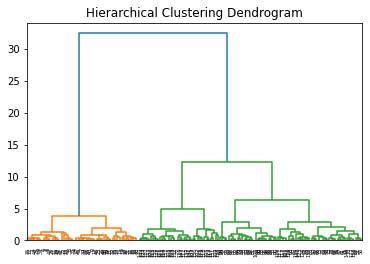

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 2 2 2 2 3 2 2 2 2
 2 2 3 3 2 2 2 2 3 2 3 2 3 2 2 3 3 2 2 2 2 2 3 3 2 2 2 3 2 2 2 3 2 2 2 3 2
 2 3]
執行時間： 0:00:02.377641
Purity: 0.8933333333333333
Silhouette Coefficient: 0.5543236611296415


In [8]:
#起始時間
start = datetime.datetime.now()
dis=sch.linkage(iris.data,metric='euclidean',method='ward')
sch.dendrogram(dis)
plt.title('Hierarchical Clustering Dendrogram')
plt.show()
Hclustering=sch.fcluster(dis,3,criterion='maxclust')
print(Hclustering)
#結束時間
end = datetime.datetime.now()
# 輸出程式花費時間
print("執行時間：", end - start)
#輸出Purity指標
print("Purity:",purity_score(iris.target, Hclustering))
#輸出Silhouette Coefficient指標
print("Silhouette Coefficient:",metrics.silhouette_score(iris.data, Hclustering,metric='euclidean'))

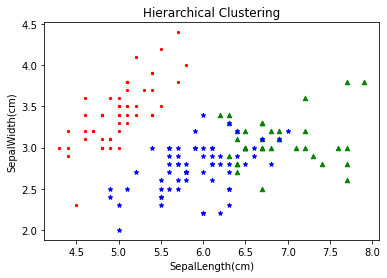

In [9]:
#散佈圖
plt.title('Hierarchical Clustering')
plt.xlabel('SepalLength(cm)')
plt.ylabel('SepalWidth(cm)')
x = iris.data[Hclustering==1]
y = iris.data[Hclustering==2]
z = iris.data[Hclustering==3]
plt.scatter(x[:, 0], x[:, 1], c="red", marker='.',s=20)  
plt.scatter(y[:, 0], y[:, 1], c="green", marker='^',s=20)  
plt.scatter(z[:, 0], z[:, 1], c="blue", marker='*',s=20)
#scatter=plt.scatter(iris.data[:,0],iris.data[:,1],c=Hclustering)
#plt.legend(handles=scatter.legend_elements()[0],labels=iris.target_names.tolist())

# DBSCAN

In [10]:
#起始時間
start = datetime.datetime.now()
#訓練
Dclustering=DBSCAN(eps=0.4,min_samples=4).fit(iris.data)
#機器自動分群並預測結果
print(Dclustering.labels_)
#結束時間
end = datetime.datetime.now()
# 輸出程式花費時間
print("執行時間：", end - start)
#輸出Purity指標
print("Purity:",purity_score(iris.target, Dclustering.labels_))
#輸出Silhouette Coefficient指標
print("Silhouette Coefficient:",metrics.silhouette_score(iris.data, Dclustering.labels_,metric='euclidean'))

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0 -1  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0
  0  0  1  1  1  1  1  1  1  3  1  1  3  1 -1  1 -1  1  1  1 -1  1  2  1
  2  1  1  1  1  1  1  1  1  1  1  2  1 -1  1 -1  1  1  1  1  1  3  1  1
  1  1  3  1 -1  2  2  2  2 -1 -1 -1 -1 -1  2  2  2  2 -1  2  2 -1 -1 -1
  2  2 -1  2  2 -1  2  2  2 -1 -1 -1  2  2 -1 -1  2  2  2  2  2  2  2  2
  2  2  2  2  2  2]
執行時間： 0:00:00.003988
Purity: 0.9266666666666666
Silhouette Coefficient: 0.32525548084540423


# 選擇DBSCAN最佳參數

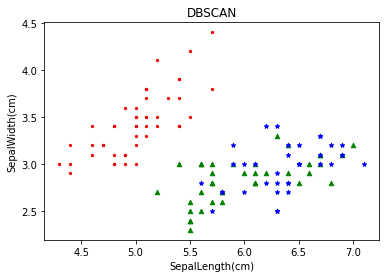

In [11]:
#散佈圖
plt.title('DBSCAN')
plt.xlabel('SepalLength(cm)')
plt.ylabel('SepalWidth(cm)')
x = iris.data[Dclustering.labels_==0]
y = iris.data[Dclustering.labels_==1]
z = iris.data[Dclustering.labels_==2]
plt.scatter(x[:, 0], x[:, 1], c="red", marker='.',s=20)  
plt.scatter(y[:, 0], y[:, 1], c="green", marker='^',s=20)  
plt.scatter(z[:, 0], z[:, 1], c="blue", marker='*',s=20)
#scatter=plt.scatter(iris.data[:,0],iris.data[:,1],marker=np.unique(Dclustering.labels_.tolist()))
#plt.legend(handles=scatter.legend_elements()[0],labels=iris.target_names.tolist())